# Практическая работа №2 

## Выполнил студент группы ББМО-01-23 Егоров Юрий Александрович №пп 12

### 13. Spark

### Пункт 1


1. Описание структуры полей логов Spark:
Логи Spark обычно содержат следующие ключевые элементы:

- Время события (Timestamp)
- Уровень логирования (Log Level) — например, INFO, WARN, ERROR
- Сообщение (Message) — текст сообщения, который описывает событие
- Поток или идентификатор задачи (Thread ID)
- Компонент, вызвавший лог (Component)

In [5]:
import re

# Пример строки лога Spark
log_line = '2023-10-01 14:30:45 INFO org.apache.spark.SparkContext: Starting job with ID 123'

# Регулярное выражение для разбора строки лога
regex_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) (\w+) ([\w\.]+): (.*)'

matches = re.match(regex_pattern, log_line)
if matches:
    timestamp = matches.group(1)
    log_level = matches.group(2)
    component = matches.group(3)
    message = matches.group(4)

    print("Timestamp:", timestamp)
    print("Log Level:", log_level)
    print("Component:", component)
    print("Message:", message)


Timestamp: 2023-10-01 14:30:45
Log Level: INFO
Component: org.apache.spark.SparkContext
Message: Starting job with ID 123


### Пункт 2 


In [11]:
import os
import re
import sqlite3
import time

# Оптимизированное регулярное выражение для парсинга строк лога
regex_pattern = r'(\d{2}/\d{2}/\d{2}) (\d{2}:\d{2}:\d{2}) (\w+) (\S+): (.*)'

# Оптимизация: потоковое чтение файла построчно
def parse_log_file(file_path, db_conn, batch_size=1000):
    with open(file_path, 'r') as file:
        cursor = db_conn.cursor()
        batch = []

        # Чтение файла построчно
        for line in file:
            match = re.match(regex_pattern, line)
            if match:
                log_date = match.group(1)
                log_time = match.group(2)
                log_level = match.group(3)
                log_source = match.group(4)
                log_message = match.group(5)

                # Добавляем в батч для последующей вставки
                batch.append((log_date, log_time, log_level, log_source, log_message))

            # Вставляем данные в базу данных батчами
            if len(batch) >= batch_size:
                cursor.executemany('INSERT INTO logs (log_date, log_time, log_level, log_source, log_message) VALUES (?, ?, ?, ?, ?)', batch)
                db_conn.commit()
                batch = []

        # Вставляем оставшиеся данные в базе
        if batch:
            cursor.executemany('INSERT INTO logs (log_date, log_time, log_level, log_source, log_message) VALUES (?, ?, ?, ?, ?)', batch)
            db_conn.commit()

# Функция для создания таблицы в базе данных
def create_table(db_conn):
    cursor = db_conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS logs (
            log_date TEXT,
            log_time TEXT,
            log_level TEXT,
            log_source TEXT,
            log_message TEXT
        )
    ''')
    db_conn.commit()

# Основная функция для запуска парсинга всех файлов в папке log и ее подкаталогах
def main():
    start_time = time.time()

    # Подключаемся к базе данных
    db_conn = sqlite3.connect('logs_optimized.db')
    
    # Создаем таблицу, если она не существует
    create_table(db_conn)

    # Указываем путь к папке с логами
    log_directory = 'log'

    # Обрабатываем все файлы в папке и ее подкаталогах
    for root, dirs, files in os.walk(log_directory):
        for filename in files:
            if filename.endswith('.log'):  # Убедитесь, что обрабатываются только файлы с расширением .log
                log_file_path = os.path.join(root, filename)
                print(f"Обработка файла: {log_file_path}")
                parse_log_file(log_file_path, db_conn)

    db_conn.close()

    print(f"Парсинг завершен за {time.time() - start_time} секунд.")

if __name__ == "__main__":
    main()


Обработка файла: log/application_1440487435730_0039/container_1440487435730_0039_01_000295.log
Обработка файла: log/application_1440487435730_0039/container_1440487435730_0039_01_000519.log
Обработка файла: log/application_1440487435730_0039/container_1440487435730_0039_01_000323.log
Обработка файла: log/application_1440487435730_0039/container_1440487435730_0039_01_000043.log
Обработка файла: log/application_1440487435730_0039/container_1440487435730_0039_01_000491.log
Обработка файла: log/application_1440487435730_0039/container_1440487435730_0039_01_000127.log
Обработка файла: log/application_1440487435730_0039/container_1440487435730_0039_01_000547.log
Обработка файла: log/application_1440487435730_0039/container_1440487435730_0039_01_000183.log
Обработка файла: log/application_1440487435730_0039/container_1440487435730_0039_01_000155.log
Обработка файла: log/application_1440487435730_0039/container_1440487435730_0039_01_000435.log
Обработка файла: log/application_1440487435730_003

### Пункт 3 

In [1]:
import sqlite3
import pandas as pd
import logging

# Настройка логирования
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

def normalize_logs_iteratively(source_db, target_db):
    logging.debug("Начинаем процесс нормализации...")

    # Подключаемся к исходной базе данных с таймаутом
    source_conn = sqlite3.connect(source_db, timeout=10)
    logging.debug(f"Подключено к исходной базе данных: {source_db}")

    # Подключаемся к целевой базе данных
    target_conn = sqlite3.connect(target_db, timeout=10)
    logging.debug(f"Подключено к целевой базе данных: {target_db}")

    # Создаем таблицу в целевой базе данных
    target_conn.execute('''
        CREATE TABLE IF NOT EXISTS normalized_logs (
            log_date TEXT,
            log_time TEXT,
            log_level TEXT,
            log_source TEXT,
            log_message TEXT
        )
    ''')
    
    logging.debug("Создана таблица для нормализованных логов.")

    # Считываем и обрабатываем данные итеративно
    for chunk in pd.read_sql_query('SELECT * FROM logs', source_conn, chunksize=10000):
        logging.debug(f"Обработка чанка с {len(chunk)} записями...")
        
        # Нормализация данных
        chunk['log_level'] = chunk['log_level'].str.lower().str.strip()  # Приведение к нижнему регистру и удаление пробелов
        chunk['log_date'] = chunk['log_date'].str.strip()  # Удаление пробелов
        chunk['log_time'] = chunk['log_time'].str.strip()  # Удаление пробелов
        chunk['log_source'] = chunk['log_source'].str.strip()  # Удаление пробелов
        chunk['log_message'] = chunk['log_message'].str.strip()  # Удаление пробелов
        
        # Сохраняем нормализованные данные в целевую базу данных
        chunk.to_sql('normalized_logs', target_conn, if_exists='append', index=False)
        logging.debug(f"Чанк с {len(chunk)} записями успешно сохранен.")

    # Закрываем соединения
    source_conn.close()
    target_conn.close()
    logging.debug("Закрыты соединения с базами данных.")
    logging.debug("Процесс нормализации завершен успешно.")

# Использование функции
normalize_logs_iteratively('logs_optimized.db', 'normalized_logs.db')


2024-10-13 13:54:49,348 - DEBUG - Начинаем процесс нормализации...
2024-10-13 13:54:49,350 - DEBUG - Подключено к исходной базе данных: logs_optimized.db
2024-10-13 13:54:49,350 - DEBUG - Подключено к целевой базе данных: normalized_logs.db
2024-10-13 13:54:49,351 - DEBUG - Создана таблица для нормализованных логов.
2024-10-13 13:54:49,374 - DEBUG - Обработка чанка с 10000 записями...
2024-10-13 13:54:49,407 - DEBUG - Чанк с 10000 записями успешно сохранен.
2024-10-13 13:54:49,426 - DEBUG - Обработка чанка с 10000 записями...
2024-10-13 13:54:49,457 - DEBUG - Чанк с 10000 записями успешно сохранен.
2024-10-13 13:54:49,473 - DEBUG - Обработка чанка с 10000 записями...
2024-10-13 13:54:49,504 - DEBUG - Чанк с 10000 записями успешно сохранен.
2024-10-13 13:54:49,523 - DEBUG - Обработка чанка с 10000 записями...
2024-10-13 13:54:49,556 - DEBUG - Чанк с 10000 записями успешно сохранен.
2024-10-13 13:54:49,573 - DEBUG - Обработка чанка с 10000 записями...
2024-10-13 13:54:49,604 - DEBUG - Ча

### Пункт 4

2024-10-13 14:01:55,252 - INFO - Подключено к базе данных: normalized_logs.db
2024-10-13 14:01:55,253 - INFO - Загружаем данные из таблицы normalized_logs...
2024-10-13 14:02:14,943 - INFO - Данные загружены, количество записей: 27410250


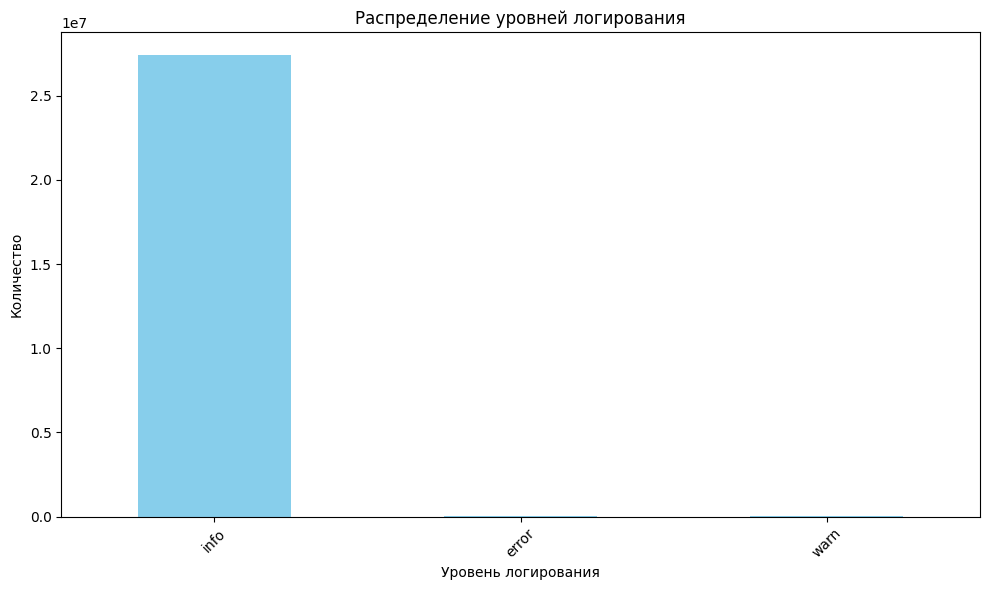

2024-10-13 14:02:17,430 - INFO - Закрыто соединение с базой данных.


In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import logging

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Подключение к базе данных
db_conn = sqlite3.connect('normalized_logs.db')
logging.info("Подключено к базе данных: normalized_logs.db")

try:
    # Загружаем только необходимые столбцы для анализа, чтобы уменьшить объем данных
    logging.info("Загружаем данные из таблицы normalized_logs...")
    logs_df = pd.read_sql_query('SELECT log_level FROM normalized_logs', db_conn)

    # Проверка, что данные загружены
    logging.info(f"Данные загружены, количество записей: {len(logs_df)}")

    # Статистический анализ
    log_level_counts = logs_df['log_level'].value_counts()

    # Визуализация
    log_level_counts.plot(kind='bar', color='skyblue', figsize=(10, 6))
    plt.xlabel('Уровень логирования')
    plt.ylabel('Количество')
    plt.title('Распределение уровней логирования')
    plt.xticks(rotation=45)
    plt.tight_layout()  # Чтобы избежать обрезания заголовков
    plt.show()

except Exception as e:
    logging.error(f"Произошла ошибка: {e}")
finally:
    # Закрываем соединение
    db_conn.close()
    logging.info("Закрыто соединение с базой данных.")


In [7]:
import sqlite3

# Подключение к базе данных
db_file = '/Users/egorov_y/CCCL/pr2/normalized_logs.db'
connection = sqlite3.connect(db_file)

# Получение информации о таблицах
query = "PRAGMA table_info(normalized_logs)"
columns_info = pd.read_sql_query(query, connection)

# Закрытие соединения с базой данных
connection.close()

# Вывод информации о столбцах
print(columns_info)


   cid         name  type  notnull dflt_value  pk
0    0     log_date  TEXT        0       None   0
1    1     log_time  TEXT        0       None   0
2    2    log_level  TEXT        0       None   0
3    3   log_source  TEXT        0       None   0
4    4  log_message  TEXT        0       None   0


2024-10-13 14:16:12,725 - INFO - Подключено к базе данных: normalized_logs.db
2024-10-13 14:16:12,726 - INFO - Загружаем данные из таблицы normalized_logs...
2024-10-13 14:20:10,679 - INFO - Данные загружены, количество записей: 27410250


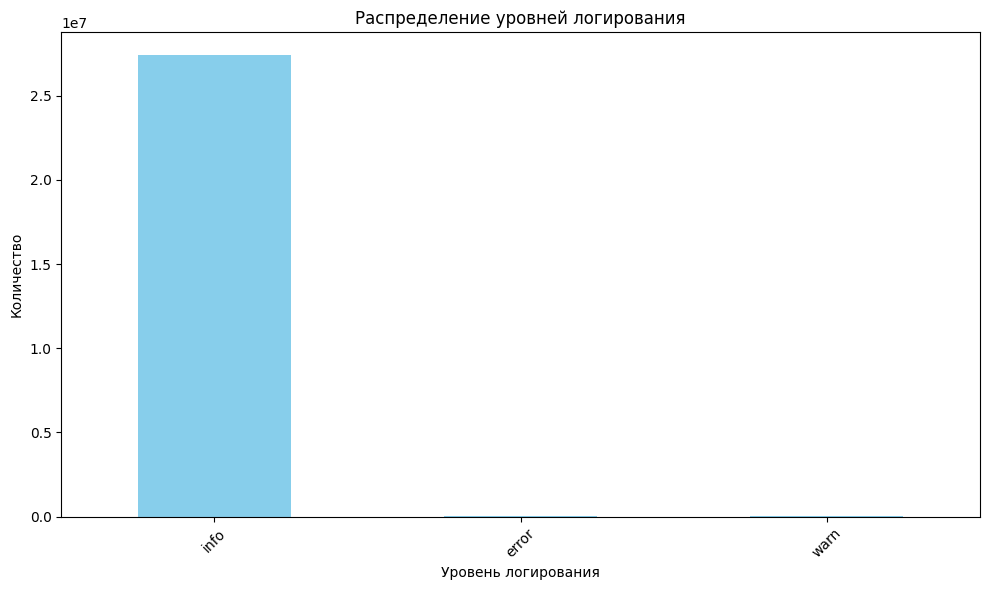

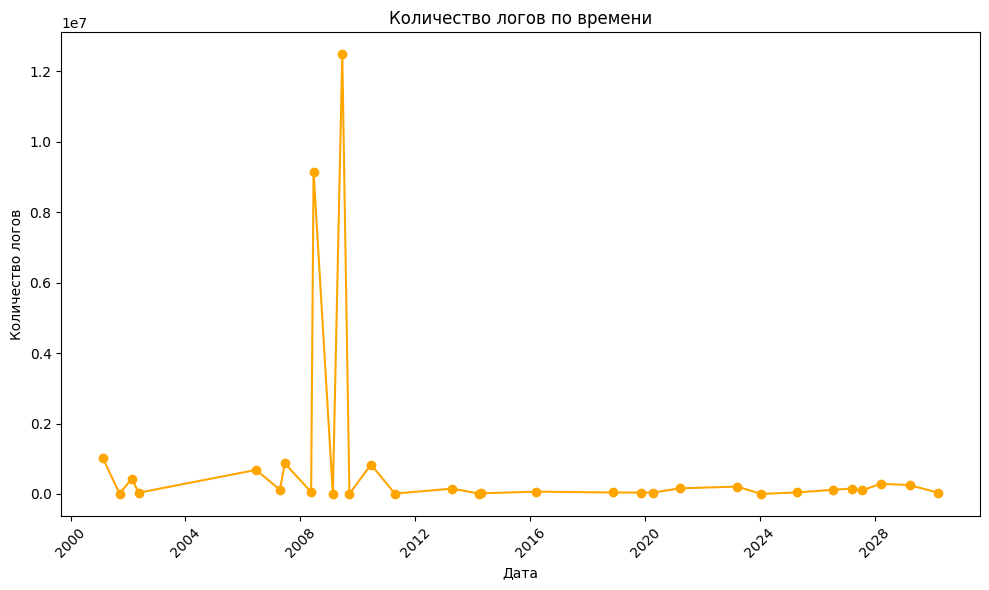

<Figure size 1200x800 with 0 Axes>

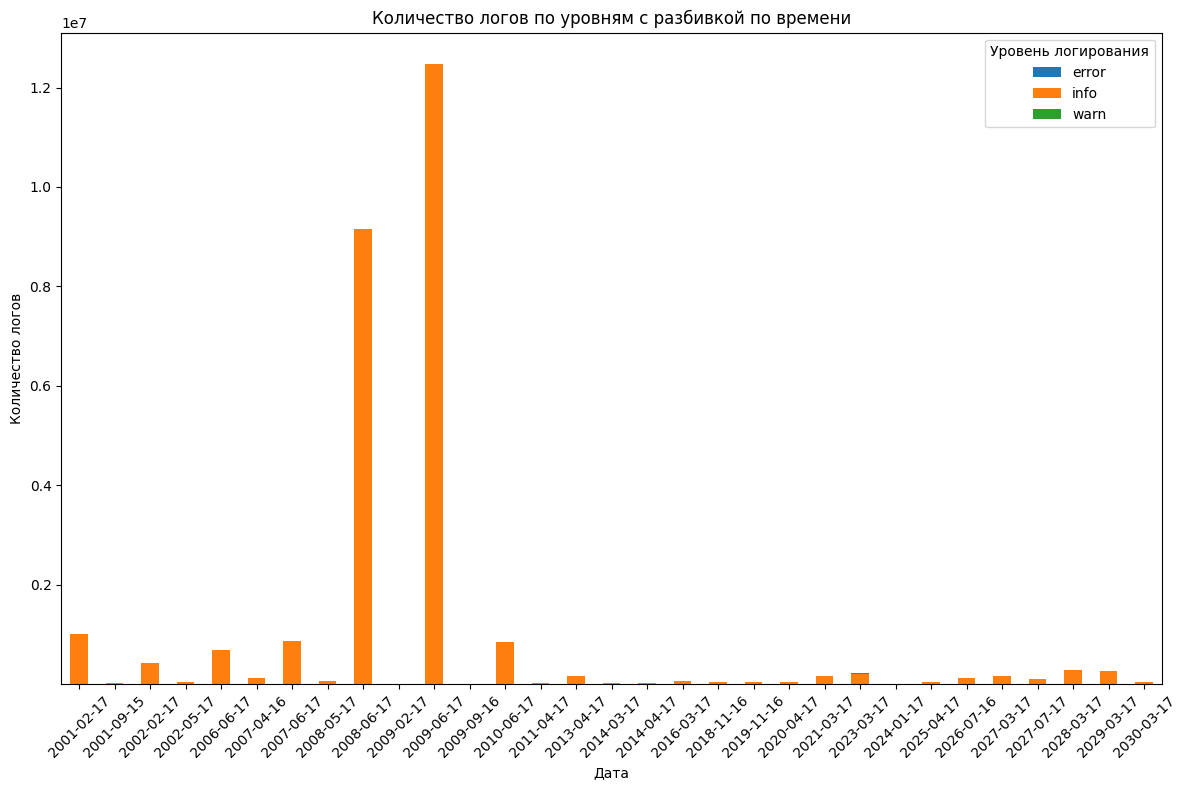

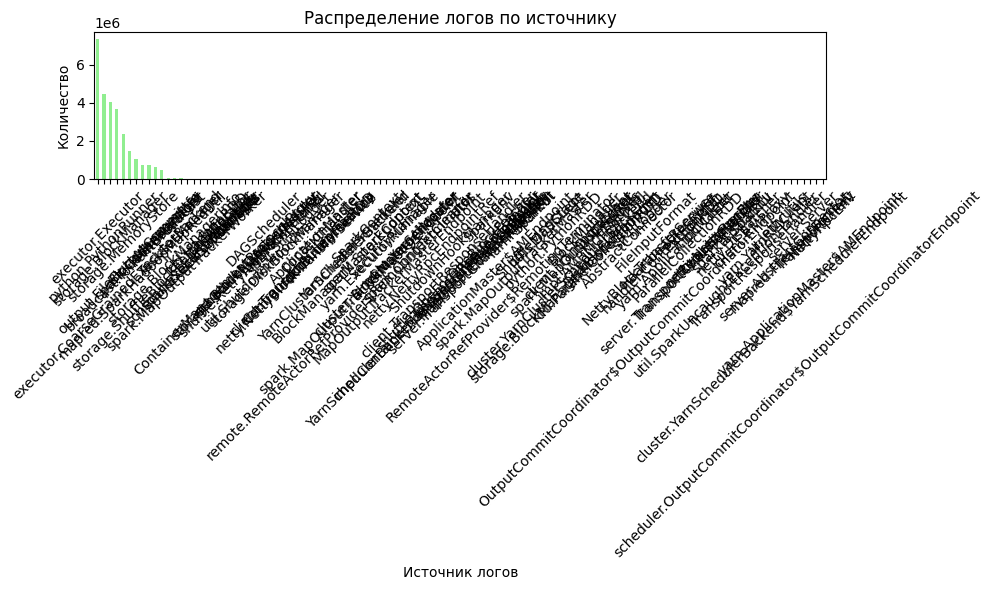

2024-10-13 14:22:40,794 - INFO - Закрыто соединение с базой данных.


In [11]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import logging

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Подключение к базе данных
db_conn = sqlite3.connect('normalized_logs.db')
logging.info("Подключено к базе данных: normalized_logs.db")

try:
    # Загружаем необходимые столбцы для анализа
    logging.info("Загружаем данные из таблицы normalized_logs...")
    logs_df = pd.read_sql_query('SELECT log_date, log_time, log_level, log_source FROM normalized_logs', db_conn)

    # Проверка, что данные загружены
    logging.info(f"Данные загружены, количество записей: {len(logs_df)}")

    # Создание временной метки из 'log_date' и 'log_time' с правильным форматом
    logs_df['timestamp'] = pd.to_datetime(logs_df['log_date'] + ' ' + logs_df['log_time'], format='%d/%m/%y %H:%M:%S')

    # Статистический анализ
    log_level_counts = logs_df['log_level'].value_counts()

    # Визуализация распределения уровней логирования
    plt.figure(figsize=(10, 6))
    log_level_counts.plot(kind='bar', color='skyblue')
    plt.xlabel('Уровень логирования')
    plt.ylabel('Количество')
    plt.title('Распределение уровней логирования')
    plt.xticks(rotation=45)
    plt.tight_layout()  # Чтобы избежать обрезания заголовков
    plt.show()

    # График количества логов по времени
    time_counts = logs_df['timestamp'].dt.date.value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    time_counts.plot(kind='line', color='orange', marker='o')
    plt.xlabel('Дата')
    plt.ylabel('Количество логов')
    plt.title('Количество логов по времени')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # График уровней логирования с разбивкой по времени
    log_levels_over_time = logs_df.groupby([logs_df['timestamp'].dt.date, 'log_level']).size().unstack(fill_value=0)

    plt.figure(figsize=(12, 8))
    log_levels_over_time.plot(kind='bar', stacked=True, figsize=(12, 8))
    plt.xlabel('Дата')
    plt.ylabel('Количество логов')
    plt.title('Количество логов по уровням с разбивкой по времени')
    plt.xticks(rotation=45)
    plt.legend(title='Уровень логирования')
    plt.tight_layout()
    plt.show()

    # График распределения логов по источнику
    log_source_counts = logs_df['log_source'].value_counts()

    plt.figure(figsize=(10, 6))
    log_source_counts.plot(kind='bar', color='lightgreen')
    plt.xlabel('Источник логов')
    plt.ylabel('Количество')
    plt.title('Распределение логов по источнику')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

except Exception as e:
    logging.error(f"Произошла ошибка: {e}")
finally:
    # Закрываем соединение
    db_conn.close()
    logging.info("Закрыто соединение с базой данных.")
